In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('../dataset/names.txt', 'r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0

itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

def build_dataset(words):
    block_size = 3 # context length
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])

            context = context[1:] + [ix] # crop the first latter and append the one ahead
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)

    return X, Y


import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xtest, Ytest = build_dataset(words[n2:])


In [6]:
Xtr.shape, Xdev.shape, Xtest.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [48]:
g = torch.Generator().manual_seed(2147483647) # To generate same random numbers everytime
vocab_size = 27
n_embd = 10
block_size = 3
n_hidden = 200

C = torch.randn((vocab_size, n_embd), generator=g)

W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
# b1 = torch.randn(n_hidden, generator=g) * 0.01

W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]

for p in parameters:
    p.requires_grad = True

sum(p.nelement() for p in parameters)

12097

In [51]:
lri = []
lossi = []
stepi = []

In [52]:
max_steps = 200000
batch_size = 32

# Iterations...
for i in range(max_steps):
    # minibatch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward Pass
    # Layer 1: Linear Layer
    emb = C[Xb] # shape = (32, 3, 10)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 # + b1

    # Layer 2: BatchNorm Layer
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact  = bngain * (hpreact - bnmeani) / bnstdi + bnbias

    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    # Layer 3: Tanh Layer
    hidden_layer = torch.tanh(hpreact) # shape = (32, 200)
    logits = hidden_layer @ W2 + b2 # shape = (32, 27)
    loss = F.cross_entropy(logits, Yb)
    
    if i%10000 == 0:
        print(f'''Iteration {i} Loss:  {loss.item()}''')

    # Backward Pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    stepi.append(i)
    lossi.append(loss.log10().item())

print(f'''Iteration {i} Loss:  {loss.item()}''')

Iteration 0 Loss:  3.2962024211883545
Iteration 10000 Loss:  2.1000280380249023
Iteration 20000 Loss:  2.27801513671875
Iteration 30000 Loss:  2.22057843208313
Iteration 40000 Loss:  2.5379388332366943
Iteration 50000 Loss:  2.3478264808654785
Iteration 60000 Loss:  2.320499897003174
Iteration 70000 Loss:  2.3527944087982178
Iteration 80000 Loss:  2.3749783039093018
Iteration 90000 Loss:  2.570277690887451
Iteration 100000 Loss:  2.321998357772827
Iteration 110000 Loss:  1.9485706090927124
Iteration 120000 Loss:  2.0786783695220947
Iteration 130000 Loss:  1.9665249586105347
Iteration 140000 Loss:  1.6663854122161865
Iteration 150000 Loss:  2.532874584197998
Iteration 160000 Loss:  2.159959554672241
Iteration 170000 Loss:  2.134035587310791
Iteration 180000 Loss:  1.891106367111206
Iteration 190000 Loss:  2.3247036933898926


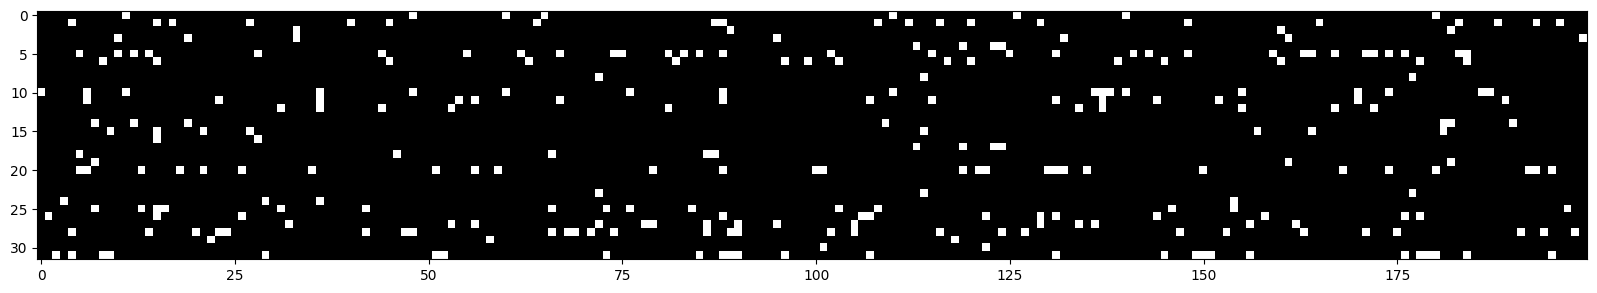

In [10]:
#plt.hist(hidden_layer.view(-1).tolist(), 50)
plt.figure(figsize=(20,10))
plt.imshow(hidden_layer.abs() > 0.99, cmap = 'gray', interpolation='nearest')

200000

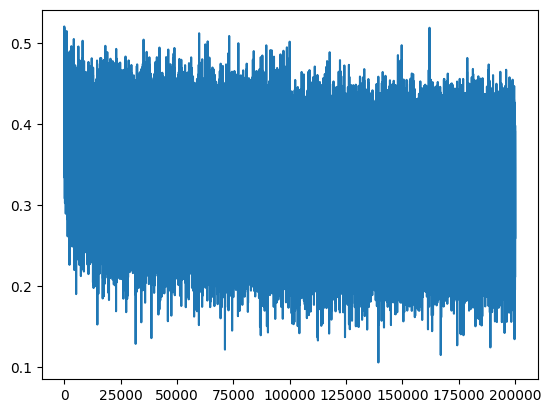

In [53]:
plt.plot(stepi, lossi)
len(lossi)

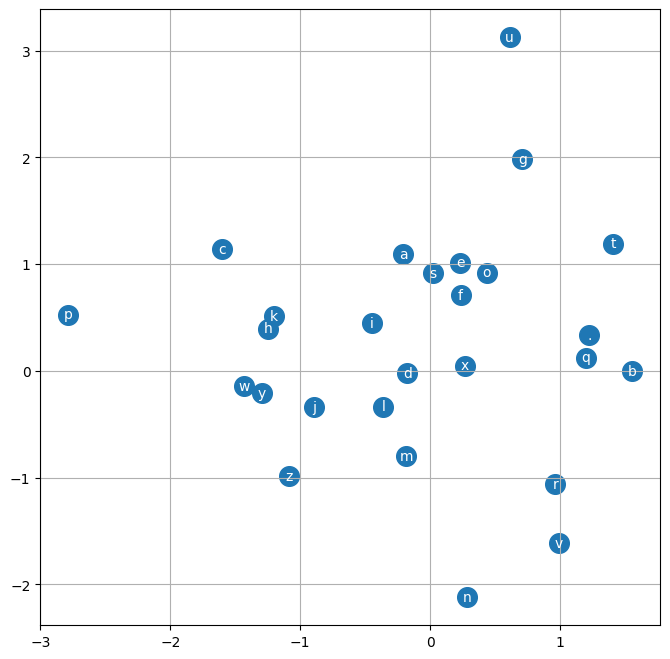

In [54]:
# Visualizing our 2d embeddings
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')

plt.grid('minor')

In [55]:
# Evaluating dev loss
emb = C[Xdev] # shape = (len(Xdev[0]), 3, 2)
hpreact = emb.view(emb.shape[0], 30) @ W1 + b1

# Implement Batch Norm
hpreact  = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

hidden_layer = torch.tanh(hpreact) # shape = (len(Xdev[0]), 100)
logits = hidden_layer @ W2 + b2 # shape = (len(Xdev[0]), 27)

loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1067, grad_fn=<NllLossBackward0>)

In [56]:
# Evaluating test loss
emb = C[Xtest] # shape = (len(Xtest[0]), 3, 2)
hpreact = emb.view(emb.shape[0], 30) @ W1 + b1
        
# Implement Batch Norm
hpreact  = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

hidden_layer = torch.tanh(hpreact) # shape = (len(Xdev[0]), 100)
logits = hidden_layer @ W2 + b2 # shape = (len(Xdev[0]), 27)

loss = F.cross_entropy(logits, Ytest)
loss

tensor(2.1060, grad_fn=<NllLossBackward0>)

In [58]:
# Sampling words

result = []
block_size = 3

for _ in range(20):
    block = [0] * block_size
    pred_word = []
    while True:
        Xt = torch.tensor([block])

        # Forward Pass
        embed = C[Xt] # shape = (1, 3, 2)
        hpreact = embed.view(embed.shape[0], -1) @ W1
        
        # # Implement Batch Norm
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias

        hidden_layer = torch.tanh(hpreact) # shape = (32, 100)
        
        logits = hidden_layer @ W2 + b2 # shape = (32, 27)

        counts = torch.exp(logits)
        prob = counts / counts.sum(1, keepdims=True)

        pred_target = torch.multinomial(prob, num_samples=1, replacement=True, generator=g)
        pred_character = itos[pred_target.item()]
        # print(pred_character)

        if pred_character == '.':
            break

        pred_word.append(pred_character)
        block = block[1:] + [pred_target.item()]

    result.append(''.join(pred_word))

result

['mumi',
 'julisia',
 'zayden',
 'neve',
 'jerrie',
 'covon',
 'carlanisa',
 'agaylen',
 'avyn',
 'tus',
 'damaghi',
 'julio',
 'railyn',
 'kryla',
 'raeiry',
 'zoaemilaydani',
 'mikame',
 'tyssine',
 'azalin',
 'sparnetarya']